In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("Data_Washington Fatal Crash Survey.csv", low_memory=False)
zips = pd.read_csv("US%20Zip%20Codes%20from%202013%20Government%20Data.txt")

In [9]:
from arcgis.geocoding import reverse_geocode
from arcgis.geometry import Geometry
from arcgis.gis import GIS

## Derive zip code for crashes 

Method: Reverse geocoding with ArcGIS and impute any missing zipcode values

In [10]:
# long : x
# lat : y

# driver zip code : dzip 
df.rename(columns={'x': 'lon', 'y': 'lat'}, inplace=True)

In [12]:
gis = GIS(api_key="AAPK206d8c337d5a416ca8a7824330c0ca7bkQWmIxSD8K5_qxX1ly5btaWLcl36cVX_1iDwCQxl_IgY56Zh6TN-Usx26i4oM77l")
# exposed for now

def get_zip(df,lon_field, lat_field):
    location = reverse_geocode((Geometry({"x":float(df[lon_field]),"y":float(df[lat_field]), "spatialReference":{"wkid":4326}})))
    return location['address']['Postal']

df['crashzip'] = df.apply(get_zip, axis=1, lat_field='lat', lon_field='lon')

In [83]:
# update missing crash zip values in df 
# case 78 03/18/2020 in county 45(Pacific) --> crash lat long improperly recorded  78.304936,  -778.304936 impossible! city = unincorporated
# FOREST SERVICES RD 2300 is not an actual road... should we drop the row?
# case 349 09/12/2021 in county 5 --> zip: 99352 could not be identified by arcGIS identified using haversine distance
# case 638 09/05/2021 in county 19(Ferry) --> lat long recorded as 78.304936,  -778.304936 impossible! city = unincorporated
# Ferry county is on a reservation in the middle of nowhere next to a natl forest far northeast of WA 
# crash occurred on BRIDGE CREEK RD in Ferry County --> brute force zip: 99138

df.loc[3690,"crashzip"] = 99352
df.loc[4128,"crashzip"] = 99138

In [84]:
# saved because computationally expensive 
# don't want to call API every time we run the code 
# DONT RUN THAT PART 

df.to_csv('crashdata_updated.csv') # import THIS data set

## What proportion of drivers are involved in fatal crashes crash in communities where they live?

Method: Calculate proportion mathematically

In [1172]:
# start from here
# processed in "preprocessing" notebook

data = pd.read_csv("crashdata_updated.csv", low_memory=False) # some cols have mixed dtypes...
data["crash_dt"]= pd.to_datetime(data["crash_dt"])

# cast as str 
data['dzip'] = data['dzip'].astype(str)
# get rid of the trailing zeros
data['dzip'] = data['dzip'].replace(r'\.0$', '', regex=True)

## Recalculate proportions-- this time community = CITY

In [1266]:
print("The proportion of drivers involved in fatal crashes in communities where they don't live = %1.4f" % (len(data.query('dcity != crashcity'))/len(data)))
print("The proportion of drivers involved in fatal crashes in communities where they live = %1.4f" % (len(data.query('dcity == crashcity'))/len(data)))

The proportion of drivers involved in fatal crashes in communities where they don't live = 0.6331
The proportion of drivers involved in fatal crashes in communities where they live = 0.3669


In [1176]:
print(data.groupby(data.crash_dt.dt.year)['dcity'].value_counts())

crash_dt  dcity      
2017      Seattle        53
          Spokane        37
          Tacoma         28
          Vancouver      22
          Yakima         19
                         ..
2021      Wishram         1
          Woodinville     1
          Woodland        1
          Woodway         1
          Yuba City       1
Name: dcity, Length: 1205, dtype: int64


## Recalculating proportions of crashes with visitors vs. residents for pre and post-pandemic
- Calculate the same proportions for before Spring 2020 and after Spring 2020
- Represent these 3 proportions in a horizontal stacked bar chart

In [1224]:
# Add another column to dataset indicating if it is pre or post covid (covid is in post-covid)
# Post-Covid is defined as March 1 2020, as the Governor of Washington declared a state of emergency on Feb 29, 2020

covid = [] # set empty list 
startdate = pd.to_datetime("2020-3-1").date()

for index, row in data.iterrows():
    if row['crash_dt']<startdate:
        covid.append("pre-pandemic") # if equal add "resident" to list
    else:
        covid.append("post-pandemic") # else add "visitor"
        
data["covid"] = covid # cast list as df column

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_25414/2784564714.py:8: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [1225]:
# Pre-pandemic
print("Pre-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they don't live = %1.4f" % (len(data[data['covid'] == "pre-pandemic"].query('dcity != crashcity'))/len(data[data['covid'] == "pre-pandemic"])))
print("Pre-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they live = %1.4f" % (len(data[data['covid'] == "pre-pandemic"].query('dcity == crashcity'))/len(data[data['covid'] == "pre-pandemic"])))

# Post-pandemic
print("Post-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they don't live = %1.4f" % (len(data[data['covid'] == "post-pandemic"].query('dcity != crashcity'))/len(data[data['covid'] == "post-pandemic"])))
print("Post-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they live = %1.4f" % (len(data[data['covid'] == "post-pandemic"].query('dcity == crashcity'))/len(data[data['covid'] == "post-pandemic"])))

Pre-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they don't live = 0.6481
Pre-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they live = 0.3519
Post-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they don't live = 0.6105
Post-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they live = 0.3895


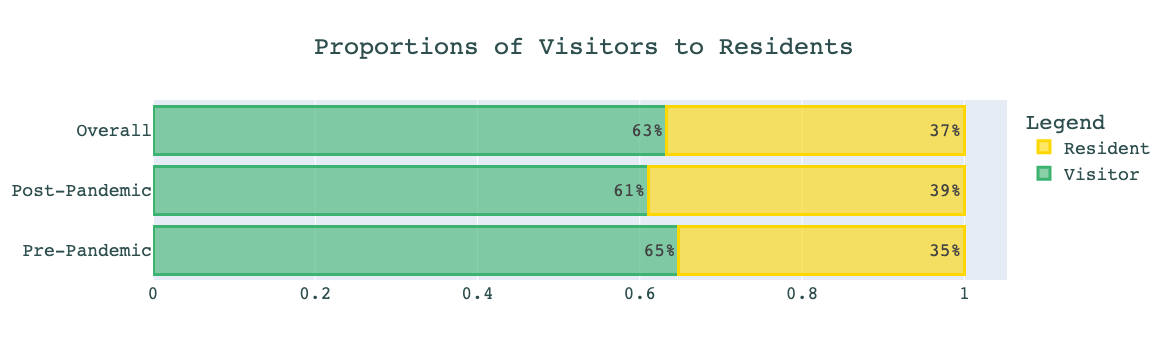

In [1290]:
import plotly.graph_objects as px

stacked = go.Figure()
stacked.add_trace(go.Bar(
    y=['Pre-Pandemic', 'Post-Pandemic', 'Overall'],
    x=[0.6481, 0.6105,  0.6331],
    text=['65%','61%','63%'],
    name='Visitor',
    orientation='h',
    marker=dict(
        color='rgba(60,179,113, 0.6)',
        line=dict(color='rgba(60,179,113, 1.0)', width=3)
    )
))
stacked.add_trace(go.Bar(
    y=['Pre-Pandemic', 'Post-Pandemic', 'Overall'],
    x=[0.3519, 0.3895, 0.3669],
    text=['35%','39%','37%'],
    name='Resident',
    orientation='h',
    marker=dict(
        color='rgba(255,215,0, 0.6)',
        line=dict(color='rgba(255,215,0, 1.0)', width=3)
    )
))

stacked.update_layout(
    legend_title="Legend",
    font=dict(
        family="Barlow, monospace",
        size=18,
        color="darkslategray"
    )
)

stacked.update_layout(
    title={
        'text': "Proportions of Visitors to Residents",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
stacked.update_layout(barmode='stack')

stacked.show()

## Is there a difference between types of crashes and behavior factors among residents vs visitors?

Method: Chi-Squared Test for Homogeneity between crashes among residents and visitors


In [1177]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

drive_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dzip']==row['crashzip']:
        drive_res.append("resident") # if equal add "resident" to list
    else:
        drive_res.append("visitor") # else add "visitor"
        
data["d_res"] = drive_res # cast list as df column

In [1178]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

### BASED ON CITY MATCH

city_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dcity']==row['crashcity']:
        city_res.append("resident") # if equal add "resident" to list
    else:
        city_res.append("visitor") # else add "visitor"
        
data["d_cty"] = city_res # cast list as df column

# "d_cty" : classifies driver as resident or visitor by CITY 
# "d_res" : classifies driver as resident or visitor by ZIP

In [1179]:
from scipy.stats import chi2_contingency

chi1 = chi2_contingency(pd.crosstab([data.year], data.d_cty, rownames=["Year"], colnames=["Driver"], margins=True, margins_name="Total"))
print("The p-value is ={}".format(chi1.pvalue))
print("The year by year distribution of visitors vs residents involved in fatal crashes does not change significantly.")

The p-value is =0.5923499100705489
The year by year distribution of visitors vs residents involved in fatal crashes does not change significantly.


In [1237]:
colist = ["numfatal", "agegrp2", "trafflow", "roadclass", "urbrur", "intersect","lanedep", "oppdir", "wrongway","pv_inv","ped_inv","ht_inv","bike_inv", "mc_inv","dd_inv", "speed_inv","drowsy_inv", "drdist_inv","aid_inv","id_inv","mj_inv","fty_inv","dr_drink","dr_alc8","dr_alc7","dr_spd","crashcity"]
values = []

for k in colist:
    pval=chi2_contingency(pd.crosstab(data[k],data["d_cty"], margins=True, margins_name="Total")).pvalue
    values.append(pval)
    
sig = dict(zip(colist, values))
print("All p-values:")
print(sig)
print("Signficant p-values:")
print({k:v for k, v in sig.items() if v < 0.05})

All p-values:
{'numfatal': 0.8817144300749307, 'agegrp2': 0.1160865472995747, 'trafflow': 2.7460967027925285e-18, 'roadclass': 4.09273701459027e-68, 'urbrur': 1.1427260420303382e-23, 'intersect': 1.2485938320723234e-09, 'lanedep': 0.00030316221944040286, 'oppdir': 0.00011065378615566232, 'wrongway': 0.007089365597776291, 'pv_inv': 0.005082584937617593, 'ped_inv': 0.0007305364989739545, 'ht_inv': 5.765121486991463e-19, 'bike_inv': 0.04146370660378593, 'mc_inv': 0.8533632086222931, 'dd_inv': 0.9898969600211072, 'speed_inv': 0.9920431928129856, 'drowsy_inv': 0.9999389138843816, 'drdist_inv': 0.9999626201861774, 'aid_inv': 0.9973993959431445, 'id_inv': 0.764343110590218, 'mj_inv': 0.8042887554573764, 'fty_inv': 0.0001585434839524297, 'dr_drink': 0.6272074595324417, 'dr_alc8': 0.8844727191708381, 'dr_alc7': 0.9999703807316164, 'dr_spd': 0.6373865200585607, 'crashcity': 0.0006708362898662284}
Signficant p-values:
{'trafflow': 2.7460967027925285e-18, 'roadclass': 4.09273701459027e-68, 'urbrur

## Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?

- We define the rate at which zip codes tend to produce higher risk drivers as the sum of drivers from each zip code divided by the 5 year span to get the average number of high risk drivers produced by a zip code per year

In [380]:
# note: we know there are 28 fatal crashes caused by drivers from CANADA

In [1181]:
# rate of drivers causing fatal crashes per zipcode per year
riskrate = pd.DataFrame(data['dzip'].value_counts()/5).head(17) # 17 instead of 15 because 15,16,17 are equal

In [1182]:
risky = pd.DataFrame(data.groupby(data.crash_dt.dt.year)['dzip'].value_counts())
risky.rename(columns={'dzip':'counts'},inplace=True)

In [1183]:
top17 = list(riskrate.index)
risky.reset_index(inplace=True)
# get data with just top 15 highest risk zip codes

highrisk = risky[risky['dzip'].isin(top17)]
print("The top 17 zip codes that produce high risk drivers are: {}".format(top17))
# 0 is canada

The top 17 zip codes that produce high risk drivers are: ['99301', '98444', '98387', '98837', '98404', '98391', '98951', '98003', '98901', '98223', '98258', '99206', '98584', '98022', '0', '98902', '98168']


In [1184]:
riskrate.reset_index(inplace=True)

In [1187]:
risky['Risk']=risky['dzip'].isin(top17).astype(int)

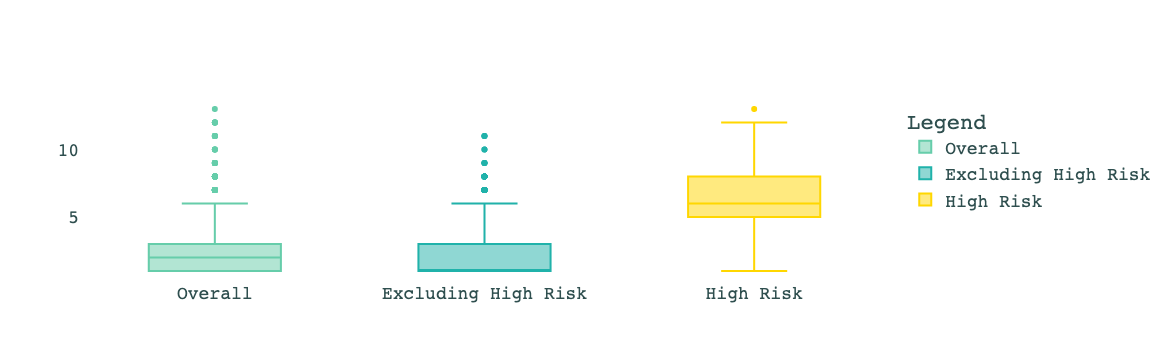

In [1333]:
fig2 = go.Figure()
fig2.add_trace(go.Box(y=risky['counts'], name='Overall',
                marker_color = 'mediumaquamarine'))
fig2.add_trace(go.Box(y=risky[risky['Risk'] == 0]['counts'], name = 'Excluding High Risk',
                marker_color = 'lightseagreen'))
fig2.add_trace(go.Box(y=risky[risky['Risk'] == 1]['counts'], name = 'High Risk',
                marker_color = 'gold'))
fig2.update_layout(
    legend_title="Legend",
    font=dict(
        family="Barlow, monospace",
        size=18,
        color="darkslategray"
    )
)

fig2.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")

fig2.show()

In [1190]:
# change name of 'index' to avoid errors 

riskrate.rename(columns={'index':'zipcode', 'dzip':'rate'}, inplace=True)

In [1192]:
riskrate.to_csv("riskrate.csv")

## What are the population demographics of these high-risk driver producing ZIP Codes?

The top 17 highest risk zip codes belong to 8 counties in WA state, excluding Canada. 

To analyze the demographics of high-risk producing zip codes, we examine the demographics of the county to which it belongs. We also examine how many people in each of the counties belong to high-risk zip codes. 

In [1198]:
# riskrate with added population demographics

# the population demographics are COUNTY level
# percent_pop : the percentage of the COUNTY's population that belong to the ZIP
# working_perc : the percentage of working age population by COUNTY

riskrate = pd.read_csv("riskrate.csv")

In [1338]:
targetzips = ['99301', '98444', '98387', '98837', '98404', '98391', '98951',
       '98003', '98901', '98223', '98258', '99206', '98584', '98022', '0',
       '98902', '98168']

# this is data where the driver belongs to high risk zip code 

newdata = data.loc[data['dzip'].isin(targetzips)]

In [1296]:
newdata.to_csv("data_hr.csv")

In [1241]:
# observation:

In [1239]:
newdata['d_res'].value_counts()

visitor     378
resident    170
Name: d_res, dtype: int64

In [1240]:
newdata['d_cty'].value_counts()

visitor     327
resident    221
Name: d_cty, dtype: int64

In [1242]:
# Most of the "high risk" zip codes are in densely populated suburbs of metropolitan areas
# Hense, some of the drivers actually live in the same city they crashed in but not the same zip code

In [1210]:
# working population data of not high risk

demo_nhr = pd.read_csv("nhr_workingpop.csv")

In [1219]:
print("The median working age percentage of the population for WA counties excluding high-risk = {}".format(demo_nhr['working_perc'].median()))
print("The median working age percentage of the population for WA counties with high-risk zips = {}".format(riskrate['working_perc'].median()))

The median working age percentage of the population for WA counties excluding high-risk = 0.5978580520563578
The median working age percentage of the population for WA counties with high-risk zips = 0.6628895092043154


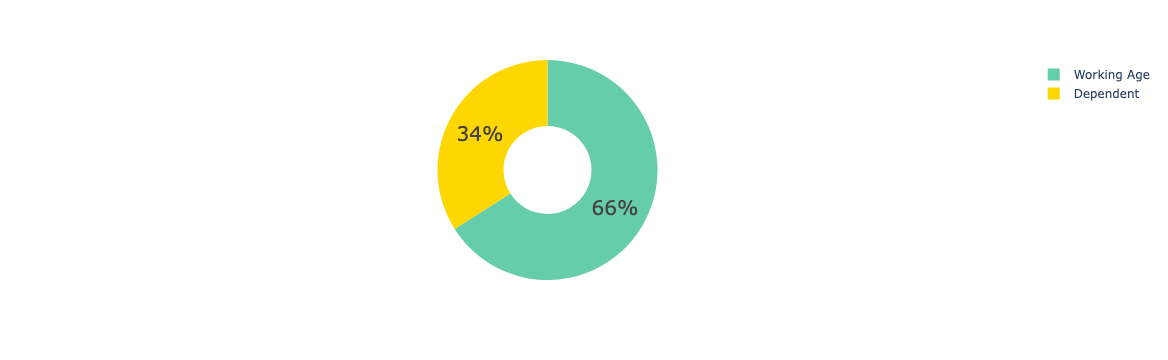

In [1324]:
import plotly.express as px

labels = ['Working Age', 'Dependent']
values = [0.66, 0.34]



fig4 = px.pie(labels, values = values, hole = 0.4,
              names = labels, color = labels,
              color_discrete_map = {'Working Age':'mediumaquamarine', 
                                    'Dependent': 'gold',
             })

fig4.update_traces(
                   title_font = dict(size=25,family='Barlow', 
                                     color='darkred'),
                   hoverinfo='label+percent',
                   textinfo='percent', textfont_size=20)

fig4.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")


fig4.show()


In [1228]:
# read in median income data 

income = pd.read_csv("med_income_washco.csv")
allinc = pd.read_csv("med_income_all.csv")

In [1229]:
counties = ['Franklin', 'Pierce', 'Grant', 'Yakima', 'King', 'Snohomish', 'Spokane', 'Mason']
nothr = allinc.loc[~allinc['County'].isin(counties)]

In [1246]:
print("The average median income of counties excluding 'high-risk' = {}".format(nothr['estinc2020'].mean()))
print("The average median income of 'high-risk' counties = {}".format(income['estinc2020'].mean()))

The average median income of counties excluding 'high-risk' = 63167.09375
The average median income of 'high-risk' counties = 73227.375


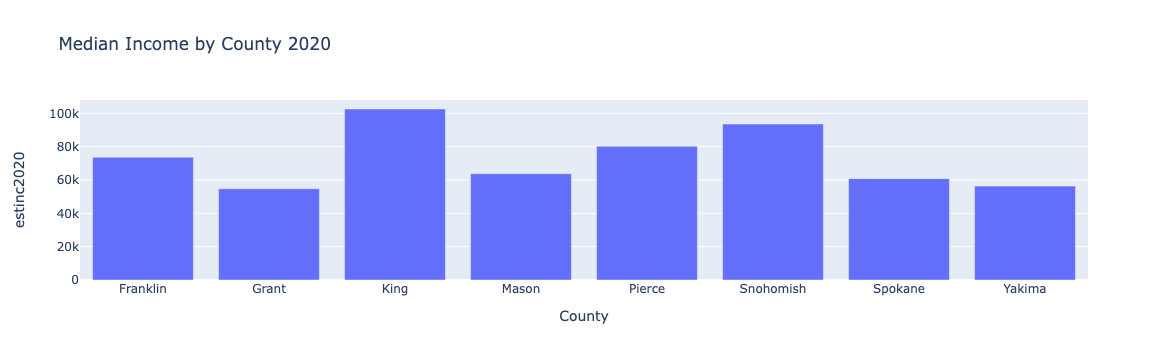

In [1247]:
fig = px.bar(income, x="County", y="estinc2020", title="Median Income by County 2020")
fig.show()

In [1260]:
riskrate

,Unnamed: 0.1,Unnamed: 0,zipcode,rate,zip_pop,SQMI,city,county,county_pop,percent_pop,...,fem_pop,wa_pop,ba_pop,ia_pop,aa_pop,na_pop,h_pop,tom_pop,working_pop,working_perc
0,0,0,99301,9.4,88426,685.57,Pasco,Franklin,97076,0.910895,...,47034,38409,1973,482,2102,200,52240,1670,61608,0.634637
1,1,1,98444,8.6,36115,6.88,Tacoma,Pierce,922828,0.039135,...,459678,596274,66213,10567,63526,15110,109959,61179,611733,0.662890
2,2,2,98387,7.0,49157,26.79,Spanaway,Pierce,922828,0.053268,...,459678,596274,66213,10567,63526,15110,109959,61179,611733,0.662890
3,3,3,98837,6.4,45823,487.02,Moses Lake,Grant,99365,0.461158,...,48481,52080,931,860,950,140,42682,1722,61130,0.615207
4,4,4,98404,6.4,36406,7.85,Tacoma,Pierce,922828,0.039450,...,459678,596274,66213,10567,63526,15110,109959,61179,611733,0.662890
5,5,5,98391,6.4,56846,40.31,Bonney Lake,Pierce,922828,0.061600,...,459678,596274,66213,10567,63526,15110,109959,61179,611733,0.662890
6,6,6,98951,6.4,14412,131.17,Wapato,Yakima,256533,0.056180,...,127937,106301,2197,9223,2976,211,131130,4495,157286,0.613122
7,7,7,98003,6.4,50704,12.08,Federal Way,King,2272571,0.022311,...,1121785,1293953,152734,13090,456352,17708,230889,107845,1588830,0.699133
8,8,8,98901,6.2,33463,159.09,Yakima,Yakima,256533,0.130443,...,127937,106301,2197,9223,2976,211,131130,4495,157286,0.613122
9,9,9,98223,6.2,45652,336.58,Arlington,Snohomish,829331,0.055047,...,410460,553800,30510,8630,102433,5028,91517,37413,557494,0.672221


In [1298]:
temp = pd.DataFrame(newdata.groupby('d_res')['crashcity'].value_counts())
temp.rename(columns={'crashcity':'counts'},inplace=True)

In [1299]:
temp.reset_index(inplace=True)

## Observations


- 0.02 (17) of zip codes make up 13.5% of the fatal crashes... why?